<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection/blob/main/Single_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision
import torchsummary

#1. Exploatory Data Analysis

In [ ]:
!wget https://www.dropbox.com/s/mdx13ya26ut2msx/iChallenge-AMD-Training400.zip?dl=0
!wget https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/raw/master/Chapter04/Fovea_location.xlsx

In [ ]:
os.mkdir('/content/data')
os.replace('/content/iChallenge-AMD-Training400.zip?dl=0', '/content/iChallenge-AMD-Training400.zip')

In [ ]:
!unzip '/content/iChallenge-AMD-Training400.zip'

In [ ]:
os.replace('/content/Training400', '/content/data/Training400')
os.replace('/content/Fovea_location.xlsx', '/content/data/Fovea_location.xlsx')

In [ ]:
path2data = '/content/data'
labels_df = pd.read_excel(f'{path2data}/Fovea_location.xlsx', index_col='ID')
labels_df=labels_df.replace(0,None)
labels_df.dropna

<bound method DataFrame.dropna of        imgName      Fovea_X      Fovea_Y
ID                                      
1    A0001.jpg  1182.264278  1022.018842
2    A0002.jpg   967.754046  1016.946655
3    A0003.jpg  1220.206714   989.944033
4    A0004.jpg  1141.140888  1000.594955
5    A0005.jpg  1127.371832  1071.109440
..         ...          ...          ...
396  N0307.jpg   823.024991   690.210211
397  N0308.jpg   647.598978   795.653188
398  N0309.jpg   624.571803   755.694880
399  N0310.jpg   687.523044   830.449187
400  N0311.jpg   746.107631   759.623062

[400 rows x 3 columns]>

In [ ]:
labels_df

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440
...,...,...,...
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880


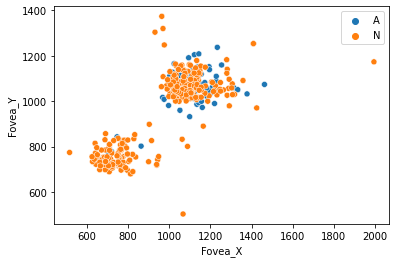

In [ ]:
AorN = [i[0] for i in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], y = labels_df['Fovea_Y'], hue=AorN)

In [ ]:
np.random.seed(32)
def load_img_label(label, id):
  image_name = label.iloc[id]
  prefix = 'AMD' if image_name[0][0] == 'A' else 'Non-AMD'
  path = f'/content/data/Training400/{prefix}/{image_name[0]}'
  img = Image.open(path)
  label = list(image_name[1:])
  return img, label

def show_img_label(img, label, w_h=(50, 50), thickness=2):
  w, h = w_h
  cx, cy = label
  draw = ImageDraw.Draw(img)
  draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline='green', width=thickness)
  plt.imshow(np.asarray(img))

(2124, 2056) [1092.93333646222, 1055.15333296773]
(2124, 2056) [1333.11527376287, 1051.06655222417]
(1444, 1444) [763.942281852489, 788.465707849387]
(1444, 1444) [706.570575779257, 793.998489614088]
(1444, 1444) [811.624012399921, 679.896508611033]
(2124, 2056) [1279.35426903255, 1183.02249912319]


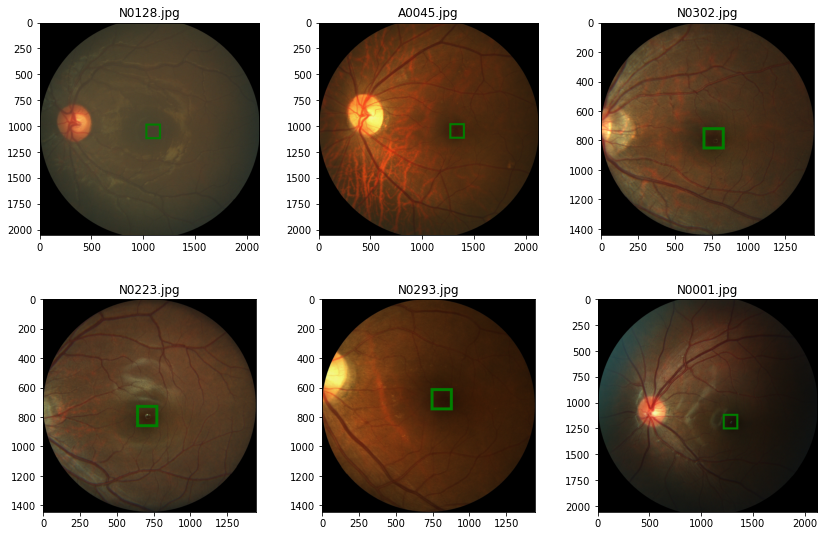

In [ ]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows, ncols = 2, 3
ids = labels_df.index
rndIds = np.random.choice(ids, nrows*ncols)


for i, id in enumerate(rndIds):
  img, label = load_img_label(labels_df, id)
  print(img.size, label)
  plt.subplot(nrows, ncols, i+1)
  show_img_label(img, label, w_h=(150, 150), thickness=20)
  plt.title(labels_df.iloc[id][0])

#2.Data Transformation

In [ ]:
def resize_img_label(img, label=(0.0, 0.0), target_size=(256, 256)):
  cx, cy = label
  w, h = img.size
  w_t, h_t = target_size
  new_img = torchvision.transforms.functional.resize(img, target_size)
  new_label = cx/w*w_t, cy/h*h_t
  return new_img, new_label

In [ ]:
def random_vflip(img, label):
  cx, cy = label
  w, h = img.size
  new_img = torchvision.transforms.functional.vflip(img)
  new_label = cx, w-cy
  return new_img, new_label

In [ ]:
def random_hflip(img, label):
  cx, cy = label
  w, h = img.size
  new_img = torchvision.transforms.functional.hflip(img)
  new_label = w-cx, cy
  return new_img, new_label

In [ ]:
def random_shift(img, label, max_translate=(0.2, 0.2)):
  cx, cy = label
  w,h = img.size
  max_w_t, max_h_t = max_translate
  trans_coef = np.random.rand()*2 - 1
  w_t = int(trans_coef * max_w_t * w)
  h_t = int(trans_coef * max_h_t * h)
  new_img = torchvision.transforms.functional.affine(img, translate=(w_t, h_t), shear=0, angle=0, scale=1)
  new_label = cx + w_t, cy + h_t
  return new_img, new_label

In [ ]:
def rescale_label(a, b):
  return list(np.array(a)*b)

def scale_label(a, b):
  return list(np.array(a)/b)

In [ ]:
def transformer(img, label, params):
  img, label = resize_img_label(img, label, params['target_size'])
  rnd = np.random.rand()
  if rnd < params['p_hflip']:
    img, label = random_hflip(img, label)
  if rnd < params['p_vflip']:
    img, label = random_vflip(img, label)
  if rnd < params['p_shift']:
    img, label = random_shift(img, label, params['max_translate'])
  if rnd < params['p_contrast']:
    contrast_factor = 1 + (rnd*2 - 1) * params['contrast_factor']
    img = torchvision.transforms.functional.adjust_contrast(img, contrast_factor)
  if rnd < params['p_brightness']:
    brightness_factor = 1 + (rnd*2 - 1) * params['brightness_factor']
    img = torchvision.transforms.functional.adjust_brightness(img, brightness_factor)
  if rnd < params['p_gamma']:
    gamma_factor = 1 + (rnd*2 - 1) * params['gamma_factor']
    img = torchvision.transforms.functional.adjust_gamma(img, gamma_factor)
  if params['scale_label']:
    label = scale_label(label, params['target_size'])

  img = torchvision.transforms.functional.to_tensor(img)
  return img, label

In [ ]:
op = np.random.randint(len(labels_df))
img, label = load_img_label(labels_df, op)
print(img.size, label)

(2124, 2056) [1065.27405676127, 1036.56648980794]


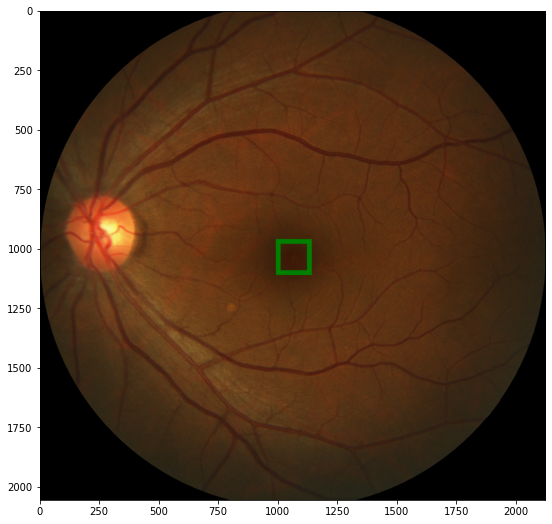

In [ ]:
show_img_label(img, label, w_h=(150, 150), thickness=20)

In [ ]:
resized_img, resized_label = resize_img_label(img, label)
print(resized_img.size, resized_label)

(256, 256) (128.3946132442962, 129.0666446453466)


In [ ]:
hfliped_img, hfliped_label = random_hflip(img, label)
print(hfliped_img.size, hfliped_label)

(2124, 2056) (1058.72594323873, 1036.56648980794)


In [ ]:
vfliped_img, vfliped_label = random_vflip(img, label)
print(vfliped_img.size, vfliped_label)

(2124, 2056) (1065.27405676127, 1087.43351019206)


In [ ]:
rndshift_img, rndshift_label = random_shift(img, label, max_translate=(0.5, 0.5))
print(rndshift_img.size, rndshift_label)

(2124, 2056) (1557.27405676127, 1512.56648980794)


The Changed Images


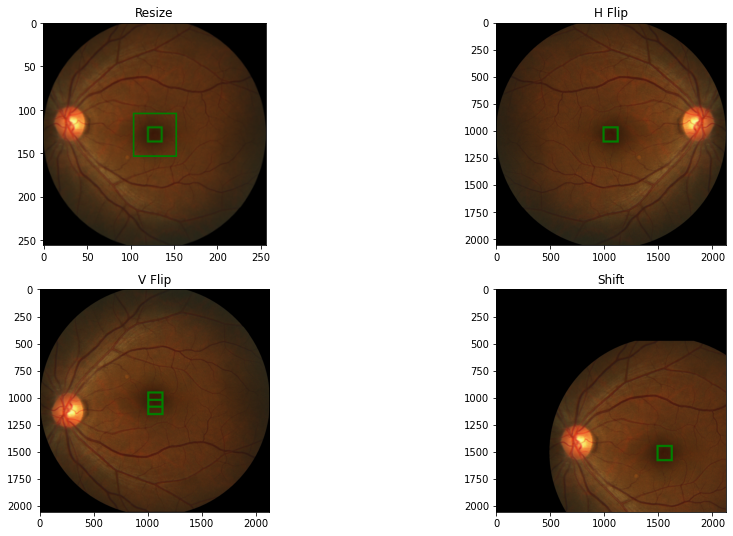

In [ ]:
plt.subplot(2, 2, 1)
show_img_label(resized_img, resized_label)
plt.title('Resize')
plt.subplot(2, 2, 2)
show_img_label(hfliped_img, hfliped_label, w_h=(150, 150), thickness=20)
plt.title('H Flip')
plt.subplot(2, 2, 3)
show_img_label(vfliped_img, vfliped_label, w_h=(150, 150), thickness=20)
plt.title('V Flip')
plt.subplot(2, 2, 4)
show_img_label(rndshift_img, rndshift_label, w_h=(150, 150), thickness=20)
plt.title('Shift')
print('The Changed Images')

In [ ]:
np.random.seed(32)
r = np.random.randint(len(labels_df))
img, label = load_img_label(labels_df, r)

params ={
    'target_size': (256, 256),
    'p_hflip': 1.0,
    'p_vflip': 1.0,
    'p_shift': 1.0,
    'max_translate': (0.5, 0.5),
    'p_brightness': 1.0,
    'brightness_factor': 0.8,
    'p_contrast': 1.0,
    'contrast_factor': 0.8,
    'p_gamma': 1.0,
    'gamma_factor': 0.4,
    'scale_label':True
}
new_img, new_label = transformer(img, label, params)

In [ ]:
ready_img = torchvision.transforms.functional.to_pil_image(new_img)

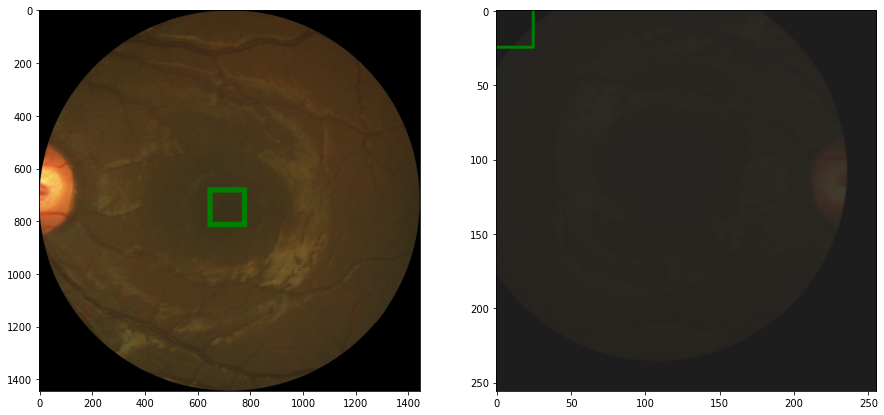

In [ ]:
plt.subplot(1, 2, 1)
show_img_label(img, label, w_h=(150, 150), thickness=20)
plt.subplot(1, 2, 2)
show_img_label(ready_img, new_label)

#3.Creating Custom Datasets

In [ ]:
class AMD_dataset(torch.utils.data.Dataset):
  def __init__(self, path2data, transform, trans_params):
    labels_df = pd.read_excel(f'{path2data}/Fovea_location.xlsx', index_col='ID')
    self.labels = labels_df[['Fovea_X', 'Fovea_Y']].values
    self.imgName = labels_df['imgName']
    self.fullPath2img = [0] * len(labels_df.index)
    for id in labels_df.index:
      if self.imgName[id][0] == "A":
        prefix='AMD'
      else:
        prefix='Non-AMD'

      self.fullPath2img[id-1] = os.path.join(path2data, 'Training400',prefix, self.imgName[id])
    self.transform = transform
    self.trans_params = trans_params
    
  def __getitem__(self, id):
    img = Image.open(self.fullPath2img[id])
    label = self.labels[id]
    img, label = self.transform(img, label, self.trans_params)
    return img, label

  def __len__(self):
    return len(self.labels)  

In [ ]:
params_train ={
    'target_size': (256, 256),
    'p_hflip': 0,
    'p_vflip': 0,
    'p_shift': 0,
    'max_translate': (0.5, 0.5),
    'p_brightness': 0,
    'brightness_factor': 0.8,
    'p_contrast': 0,
    'contrast_factor': 0.8,
    'p_gamma': 0,
    'gamma_factor': 0.4,
    'scale_label':True
}

params_val ={
    'target_size': (256, 256),
    'p_hflip': 0.5,
    'p_vflip': 0.5,
    'p_shift': 0.5,
    'max_translate': (0.5, 0.5),
    'p_brightness': 0.5,
    'brightness_factor': 0.8,
    'p_contrast': 0.5,
    'contrast_factor': 0.8,
    'p_gamma': 0.5,
    'gamma_factor': 0.4,
    'scale_label':True
}

amd_ds1 = AMD_dataset('/content/data/', transformer, params_train)
amd_ds2 = AMD_dataset('/content/data/', transformer, params_val)

In [ ]:
#Split to Train/Test Data
from sklearn import model_selection
ss = model_selection.ShuffleSplit(n_splits=1, test_size=0.2, random_state=32)

for train_id, val_id in ss.split(range(len(amd_ds1))):
  print(len(train_id), len(val_id))
  
  train_ds = torch.utils.data.Subset(amd_ds1, train_id)
  val_ds = torch.utils.data.Subset(amd_ds2, val_id)

320 80


In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=True)

In [ ]:
# After defining data loaders, always check to see that the returned batch is
# in the appropriate shape.
for i, l in train_dl:
  print(i.shape, i.dtype)
  break

torch.Size([8, 3, 256, 256]) torch.float32


#4.Model
###With Residual(skip connection) Trick

In [ ]:
import torch.nn as nn

In [ ]:
class Net(nn.Module):
  def __init__(self, params):
    super(Net, self).__init__()
    c, h, w = params['input_shape']
    f = params['initial_filters']
    num_outputs = params['num_outputs']
# The number of input channels, in the case of skip connections, will be the sum of the output channels from
# the previous layer and the skip layer.
    self.conv1 = nn.Conv2d(c, f, kernel_size=3, padding=1, stride=2)
    self.conv2 = nn.Conv2d(f + c, 2*f, kernel_size=3, padding=1, stride=1)
    self.conv3 = nn.Conv2d(3*f + c, 4*f, kernel_size=3, padding=1, stride=1)
    self.conv4 = nn.Conv2d(7*f + c, 8*f, kernel_size=3, padding=1, stride=1)
    self.conv5 = nn.Conv2d(15*f + c, 16*f, kernel_size=3, padding=1, stride=1)
    self.fc1 = nn.Linear(16*f, num_outputs)
  
  def forward(self, x):
    identify = nn.functional.avg_pool2d(x, 4, 4)
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = nn.functional.max_pool2d(x, 2, 2)    
    x = torch.cat((x, identify), dim=1)  ##Residual (Skip) Learning technic

    identify = nn.functional.avg_pool2d(x, 2, 2)
    x = self.conv2(x)
    x = nn.functional.relu(x)
    x = nn.functional.max_pool2d(x, 2, 2)
    x = torch.cat((x, identify), dim=1)

    identify = nn.functional.avg_pool2d(x, 2, 2)
    x = self.conv3(x)
    x = nn.functional.relu(x)
    x = nn.functional.max_pool2d(x, 2, 2)
    x = torch.cat((x, identify), dim=1)

    identify = nn.functional.avg_pool2d(x, 2, 2)
    x = self.conv4(x)
    x = nn.functional.relu(x)
    x = nn.functional.max_pool2d(x, 2, 2)
    x = torch.cat((x, identify), dim=1)

    x = self.conv5(x)
    x = nn.functional.relu(x)
    x = nn.functional.adaptive_avg_pool2d(x, 1)
    x = x.reshape(x.size(0), -1)
    x = self.fc1(x)
    return x

In [ ]:
model_params = {
    'input_shape': (3, 256, 256),
    'initial_filters': 16,
    'num_outputs': 2
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = Net(model_params)
model = model.to(device)

In [ ]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
def c2box(cordinates, w=50.0/256, h=50.0/256):
  tensor_w = torch.ones(cordinates.shape[0], 1, device=cordinates.device) * w
  tensor_h = torch.ones(cordinates.shape[0], 1, device=cordinates.device) * h
  cx = cordinates[:, 0].unsqueeze(1)
  cy = cordinates[:, 1].unsqueeze(1)
  boxes = torch.cat((cx, cy, tensor_w, tensor_h), -1) #==>(cx,cy,w,h)
  return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,    #==>(xmin, xmax)
                    boxes[:, :2] + boxes[:, 2:]/2), 1) #==>(ymin, ymax)

In [ ]:
def loss_epoch(model, loss_fn, dataset, sanity_check=False, opt=None):
  running_loss, running_metric = 0.0, 0.0
  len_data = len(dataset.dataset)
  for x, y in dataset:
    y = torch.stack(y, 1)
    y = y.type(torch.float32).to(device)
    output = model(x.to(device))
    # x = x.to(device)
    # output = model(x)
    loss = loss_fn(output, y)
    output = c2box(output)
    y = c2box(y)
    iou = torchvision.ops.box_iou(output, y)
    metric_b = torch.diagonal(iou, 0).sum().item()


    if opt is not None:
      opt.zero_grad()
      loss.backward()
      opt.step()
    
    
    loss_b,metric_b = loss.item(), metric_b
    running_loss += loss_b
    
    if metric_b is not None:
      running_metric += metric_b
    
    if sanity_check:
      break

  loss = running_loss / float(len_data)
  metric = running_metric / float(len_data)  

  return loss, metric

In [ ]:
def train_val(model, params):
  num_epochs = params['num_epochs']
  loss_fn = params['loss_fn']
  opt = params['optimizer']
  train_dl = params['train_dl']
  val_dl = params['val_dl']
  sanity_check = params['sanity_check']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  loss_history = {
      'train': [],
      'val': []
  }
  
  metric_history = {
      'train': [],
      'val': []
  }
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  for epoch in range(num_epochs):
    current_lr = get_lr(opt)

    model.train()
    train_loss, train_metric = loss_epoch(model, loss_fn, train_dl, sanity_check, opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_fn, val_dl, sanity_check)
    
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)
    
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print('Best Loss Saved')
    
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print('Loading The Best Model')
      model.load_state_dict(best_model_wts)

    print(f"Epoch: {epoch+1}/{num_epochs}, current lr={current_lr}, Train Loss: {train_loss:.4f}, Train Accuracy: %{train_metric*100:.3f}, Val Loss: {val_loss:.4f}, Val Accuracy: %{val_metric*100:.3f}")
    
  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

In [ ]:
loss_fn = nn.SmoothL1Loss(reduction='sum')

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

In [ ]:
# os.mkdir('/content/models')

params_train = {
    'num_epochs': 100,
    'optimizer': opt,
    'loss_fn': loss_fn,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'sanity_check' : False,
    'lr_scheduler': lr_scheduler,
    'path2weights': '/content/models/resnet18.pt'
}

In [ ]:
model, loss_history, metric_history = train_val(model, params_train)

Best Loss Saved
Epoch: 1/100, current lr=0.0003, Train Loss: 0.0369, Train Accuracy: %21.245, Val Loss: 0.0575, Val Accuracy: %18.083
Best Loss Saved
Epoch: 2/100, current lr=0.0003, Train Loss: 0.0071, Train Accuracy: %47.364, Val Loss: 0.0499, Val Accuracy: %32.713
Best Loss Saved
Epoch: 3/100, current lr=0.0003, Train Loss: 0.0055, Train Accuracy: %53.506, Val Loss: 0.0375, Val Accuracy: %35.219
Epoch: 4/100, current lr=0.0003, Train Loss: 0.0055, Train Accuracy: %56.005, Val Loss: 0.0487, Val Accuracy: %30.625
Epoch: 5/100, current lr=0.0003, Train Loss: 0.0054, Train Accuracy: %54.150, Val Loss: 0.0434, Val Accuracy: %30.831
Epoch: 6/100, current lr=0.0003, Train Loss: 0.0051, Train Accuracy: %57.807, Val Loss: 0.0455, Val Accuracy: %37.083
Epoch: 7/100, current lr=0.0003, Train Loss: 0.0054, Train Accuracy: %55.138, Val Loss: 0.0389, Val Accuracy: %34.827
Epoch: 8/100, current lr=0.0003, Train Loss: 0.0052, Train Accuracy: %55.741, Val Loss: 0.0578, Val Accuracy: %24.357
Epoch: 9

In [ ]:
def plot_history(history, loss=True):

  num_epochs = len(history['train'])
  print(num_epochs)
  title = 'Loss' if loss else 'Accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history['train'], label='Train')
  plt.plot(range(1, num_epochs+1), history['val'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

100


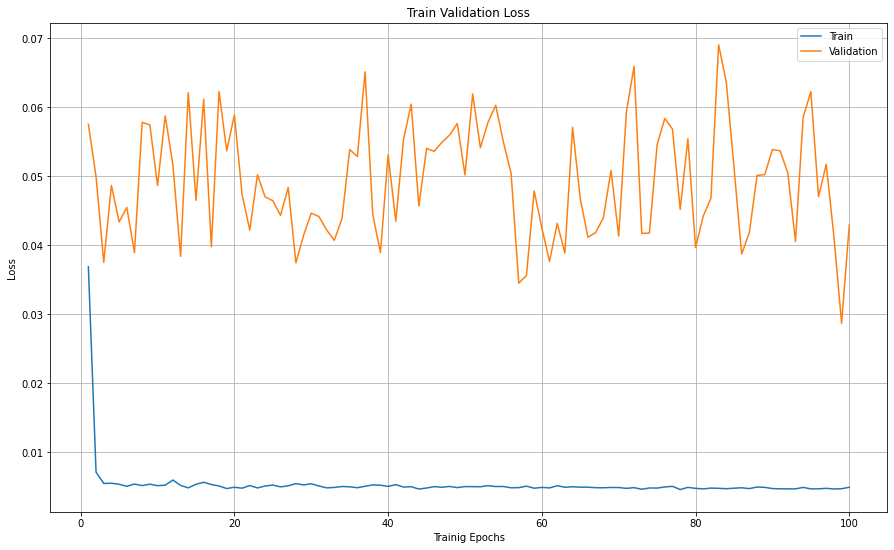

In [ ]:
plot_history(loss_history, True)

100


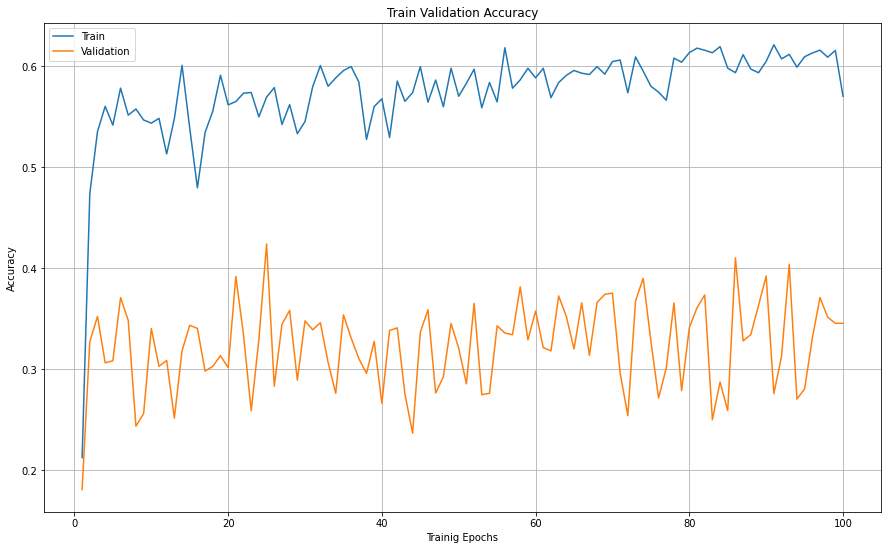

In [ ]:
plot_history(metric_history, False)

#Deploy

In [ ]:
def show_tensor_2labels(img,label1,label2,w_h=(50,50)): 
    label1=rescale_label(label1,img.shape[1:])
    label2=rescale_label(label2,img.shape[1:])
    img=torchvision.transforms.functional.to_pil_image(img) 

    w,h=w_h 
    cx,cy=label1
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="green",width=2)

    cx,cy=label2
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="red",width=2)

    plt.imshow(np.asarray(img))

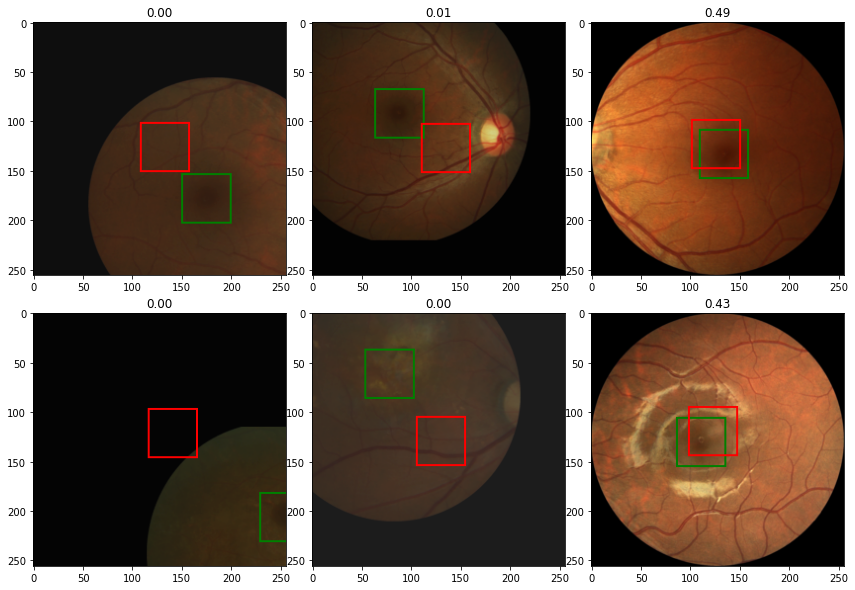

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplots_adjust(wspace=0.0, hspace=0.15)

rndInds=np.random.randint(len(val_ds),size=10)
for i,rndi in enumerate(rndInds):
    img,label=val_ds[rndi]
    h,w=img.shape[1:]
    with torch.no_grad():
        label_pred=model(img.unsqueeze(0).to(device))[0].cpu()
        
    plt.subplot(2,3,i+1)
    show_tensor_2labels(img,label,label_pred)
    
    # calculate IOU 
    label_bb=c2box(torch.tensor(label).unsqueeze(0))
    label_pred_bb=c2box(label_pred.unsqueeze(0))
    iou=torchvision.ops.box_iou(label_bb, label_pred_bb)        
    plt.title("%.2f" %iou.item())

    if i>4:
        break

In [ ]:
def load_img_label(labels_df,id_):    
    imgName=labels_df["imgName"]    
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
            
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    img = Image.open(fullPath2img)
    
    # centroid
    x=labels_df["Fovea_X"][id_]
    y=labels_df["Fovea_Y"][id_]
    
    label=(x,y)
    return img,label

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)
torch.Size([3, 256, 256])


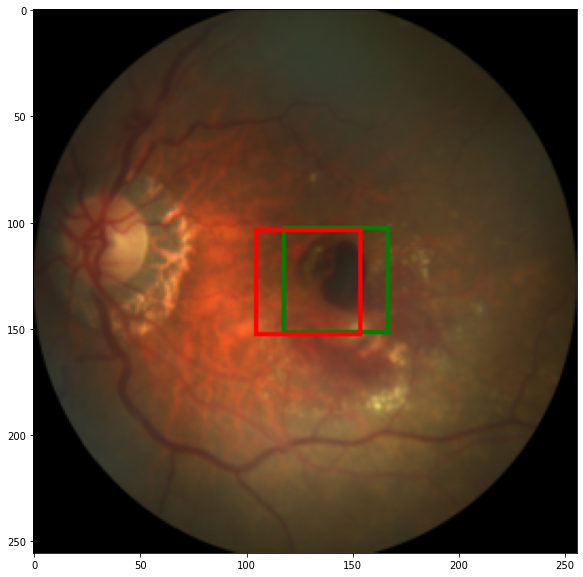

In [ ]:
img,label=load_img_label(labels_df,1)   
print(img.size, label)

img,label=resize_img_label(img,label,target_size=(256,256))
print(img.size, label)

img=torchvision.transforms.functional.to_tensor(img)
label=scale_label(label,(256,256))
print(img.shape)

with torch.no_grad():
    label_pred=model(img.unsqueeze(0).to(device))[0].cpu()

show_tensor_2labels(img,label,label_pred)